# Getting started

jWave is written by following the kWave interface as close as possible, deviating only when required by the functional programming style required by JAX. 

Therefore, it should feel natural to write simulation scripts. 

## Single frequency simulations

Running single frequency simulations reduces to solving the Helmholtz equation
$$
\left(\nabla^2 + \frac{\omega^2}{c^2}\right)u = \rho.
$$

### Setup simulation
First, we need to define the grid on which the problem is defined. This is done by creating a `kGrid` "structure". We are also going to import `jax.numpy` to manipulate arrays when needed and `pyplot` to make plots

In [1]:
from jax import numpy as jnp
from matplotlib import pyplot as plt

In [2]:
from jwave.geometry import kGrid

N = (128,128)   # Grid size
dx = (1., 1.)   # Grid spacings
omega = 1.      # angular frequency 2*pi*f_0

grid = kGrid.make_grid(N, dx)

The grid structure contains the following fields:

In [3]:
grid._fields

('N', 'dx', 'k_vec', 'k_staggered', 'k_with_kspaceop', 'space_axis')

The first two are the inputs we just gave to the constructor. `k_vec` a list containing the frequency axes, while `space_axis` contains the spatial axes. The other two fields, `k_staggered` and `k_with_kspaceop`, are initialized as empty and populated only if needed.

We can now define the acoustic properties of the domain in a `Medium` structure

In [4]:
from jwave.geometry import Medium

medium = Medium(
    sound_speed=jnp.ones(N),
    density=1.0, 
    attenuation=0.0, 
    pml_size=15
)

Note that even if we can define `density` and `attenuation`, they are not going to be used by `solve_helmholtz`.

Last, we need to define the sources. For the Helmholtz equation, we need to use `ComplexSources`, which are defined by a position and a (complex) amplitude

In [5]:
from jwave.geometry import ComplexSources

x_pos = [32, 56]
y_pos = [44, 88]
amplitude = [1., 1j]
sources = ComplexSources((x_pos, y_pos), amplitude)

We can easily transform our `ComplexSources` object into the corresponding field with the method `to_field()`

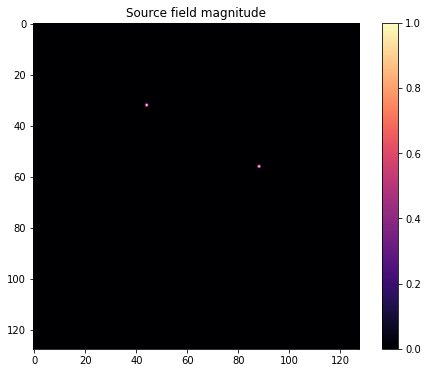

In [6]:
source_field = sources.to_field(grid)

plt.figure(figsize=(8,6))
plt.imshow(jnp.abs(source_field), cmap="magma"), plt.colorbar()
plt.title("Source field magnitude")
plt.show()

### Run the simulation

The simulation can be solved using `solve_helmholtz`, which internally builds the Helmholtz operator and solves the equation with an iterative solver.

Text(0.5, 1.0, 'Imaginary wavefield')

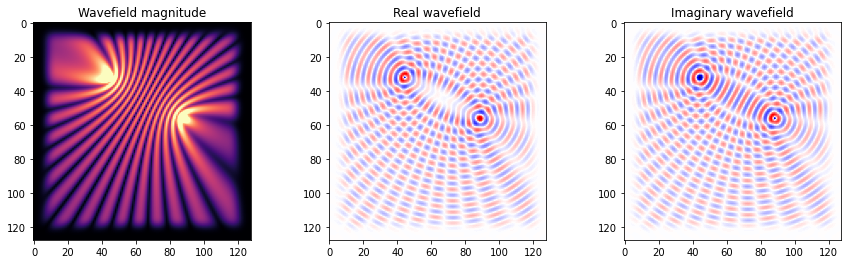

In [7]:
from jwave.physics import solve_helmholtz

field = solve_helmholtz(
    grid, 
    medium, #
    source_field, 
    omega
)

# Plot field
fig, axes = plt.subplots(1,3,figsize=(15,4))
axes[0].imshow(jnp.abs(field), vmax=0.1, cmap="magma")
axes[0].set_title("Wavefield magnitude")
axes[1].imshow(field.real, vmin=-.3, vmax=.3, cmap="seismic")
axes[1].set_title("Real wavefield")
axes[2].imshow(field.imag, vmin=-.3, vmax=.3, cmap="seismic")
axes[2].set_title("Imaginary wavefield")

## Wave simulation

Writing scripts for time-varying simulation is pretty much identical to the single frequency case. However, sources must be defined using the class `Sources` and it is necessary to define a time axis.

Time steps: 599


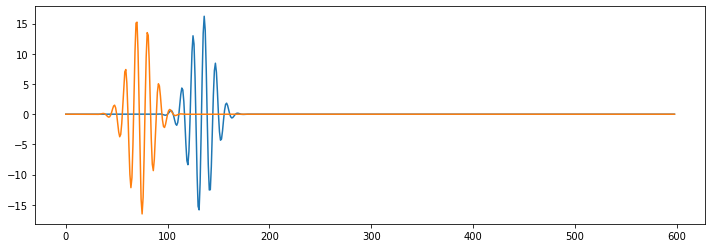

In [8]:
from jwave.geometry import TimeAxis, Sources
from jwave.signal_processing import apply_ramp, gaussian_window

# Making time axis
cfl = 0.3
time_axis = TimeAxis.from_kgrid(grid, medium, cfl=cfl)

# Making sources
# (sources are treated as mass terms)
source_freq = 0.3
source_mag = 5/time_axis.dt
t = time_axis.to_array()

s1 = source_mag * jnp.sin(2 * jnp.pi * source_freq * t)
s1 = gaussian_window(
    apply_ramp(s1, time_axis.dt, source_freq),
    t,
    40,
    5
)
s2 = source_mag * jnp.sin(2 * jnp.pi * source_freq * t)
s2 = gaussian_window(
    apply_ramp(s2, time_axis.dt, source_freq),
    t,
    22,
    5
)

source_signals = jnp.stack([s1, s2])
sources = Sources(positions=(x_pos, y_pos), signals=source_signals)

# Plot source signals
plt.figure(figsize=(12,4))
plt.plot(source_signals.T)
print("Time steps: {}".format(len(t)))

In [9]:
from jwave.physics import simulate_wave_propagation

u, rho = simulate_wave_propagation(
    grid, 
    medium, 
    time_axis, 
    sources
)

print("Output shape (timestep, dimensions, height, width) = {}".format(rho.shape))

Output shape (timestep, dimensions, height, width) = (599, 2, 128, 128)


An user can also input a set of `Sensors` to restrict the output to specific grid locations

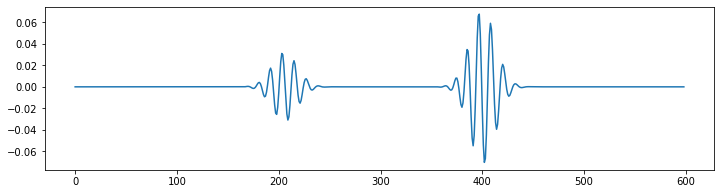

In [10]:
from jwave.geometry import Sensors

sensors = Sensors(positions=([96],[96]))

u_traces, rho_traces = simulate_wave_propagation(
    grid, 
    medium, 
    time_axis, 
    sources,
    sensors=sensors
)

# Plot first sensor horizontal velocity signal
plt.figure(figsize=(12,3))
plt.plot(u_traces[:,1,0])

Alternatively, any function accepting an input tuple representing the fields can be used as "sensor" (or more generally, as a measurement operator, see docs for [`generalized_semi_implicit_euler`](/api_ode/#jwave.ode.generalized_semi_implicit_euler))

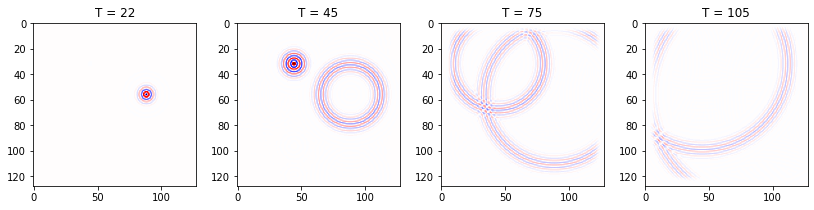

In [11]:
def get_pressure(fields):
    u, rho = fields
    return jnp.sum(rho,0)*(medium.sound_speed**2)

pressure = simulate_wave_propagation(
    grid, 
    medium, 
    time_axis, 
    sources,
    sensors = get_pressure
)

# Plot pressure at a few timesteps
timesteps = [75, 150, 250, 350]
fig, axes = plt.subplots(1,4, figsize=(14,3))
for x in range(4):
    axes[x].imshow(pressure[timesteps[x]], vmin=-1, vmax=1, cmap="seismic")
    axes[x].set_title("T = {}".format(int(timesteps[x]*time_axis.dt)))

## Compiling functions

Let's check the time required for a single-frequency simulation. Note that we need to use `.block_until_ready()` to get correct timings, because of [JAX asynchronous dispatch](https://jax.readthedocs.io/en/latest/async_dispatch.html)

In [12]:
%timeit solve_helmholtz(grid, medium, source_field, omega).block_until_ready()

2 s ± 105 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


`JAX` allows to compile the functions [with *just-in-time (jit)* compilation](https://jax.readthedocs.io/en/latest/notebooks/thinking_in_jax.html#To-JIT-or-not-to-JIT). Compiling functions is done using the `jax.jit` decorator. 
Compilation applies all sort of tricks to the computational graph of a function, such as fusing operation, avoiding temporary arrays allocation, etc. To make this possible, `jax` needs to know the shapes of all arrays involved in the computation, therefore all arrays need to have static shapes.

For example, we can't compile the function

```python
def new_array(x):
    lenght = int(jnp.sum(x))
    return jnp.zeros(shape=(lenght,))
```

since the size of the output array depends on the content of x. A similar argument holds for `if/else` branches, non hashable inputs (such as strings): see [this page](https://jax.readthedocs.io/en/latest/notebooks/thinking_in_jax.html#To-JIT-or-not-to-JIT) for further details about JIT compilation. 

In general, an easy way to often make a function jittable is to wrap it around another function that takes only traceable objects (such as arrays) as input. The other inputs to the original function will be treated as static argument, making the computational graph unambiguous. In the case of our helmholtz problem, we often want to solve several problems with a fixed grid size, therefore we can treat the `grid` argument as static and wrap the function as follows

In [13]:
def _wrapped_solve_helmholtz(medium, source_field, omega):
    return solve_helmholtz(grid, medium, source_field, omega)

The function can now be compiled

In [14]:
from jax import jit

fast_solve = jit(_wrapped_solve_helmholtz)        # Returns the xla call for compiling the function
field = fast_solve(medium, source_field, omega)   # The function is actually compiled at its first call

In [15]:
print("Runtimes for the original function")
%timeit solve_helmholtz(grid, medium, source_field, omega).block_until_ready()

Runtimes for the original function
1.93 s ± 41.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [16]:
print("Runtimes for the compiled function")
%timeit fast_solve(medium, source_field, omega).block_until_ready()

Runtimes for the compiled function
258 ms ± 3.33 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
